XGBoost Trading Signal Model - Training and Testing

[1/7] Loading datasets...
Training data shape: (3990, 71)
Testing data shape: (1444, 71)

[2/7] Identifying common features...
Common features found: 59

Feature list:
    1. body_size
    2. dmi_adx
    3. dmi_minus
    4. dmi_plus
    5. exit_klu_idx
    6. exit_price
    7. feat_bsp1_bi_amp
    8. feat_bsp1_bi_amp_rate
    9. feat_bsp1_bi_klu_cnt
   10. feat_bsp2_bi_amp
   11. feat_bsp2_bi_amp_rate
   12. feat_bsp2_bi_klu_cnt
   13. feat_bsp2_break_bi_amp
   14. feat_bsp2_break_bi_amp_rate
   15. feat_bsp2_break_bi_bi_klu_cnt
   16. feat_bsp2_retrace_rate
   17. feat_bsp2s_bi_amp
   18. feat_bsp2s_bi_amp_rate
   19. feat_bsp2s_bi_klu_cnt
   20. feat_bsp2s_break_bi_amp
   21. feat_bsp2s_break_bi_amp_rate
   22. feat_bsp2s_break_bi_klu_cnt
   23. feat_bsp2s_lv
   24. feat_bsp2s_retrace_rate
   25. feat_bsp3_bi_amp
   26. feat_bsp3_bi_amp_rate
   27. feat_bsp3_bi_klu_cnt
   28. feat_bsp3_zs_height
   29. feat_bsp_bi_amp
   30. feat_d

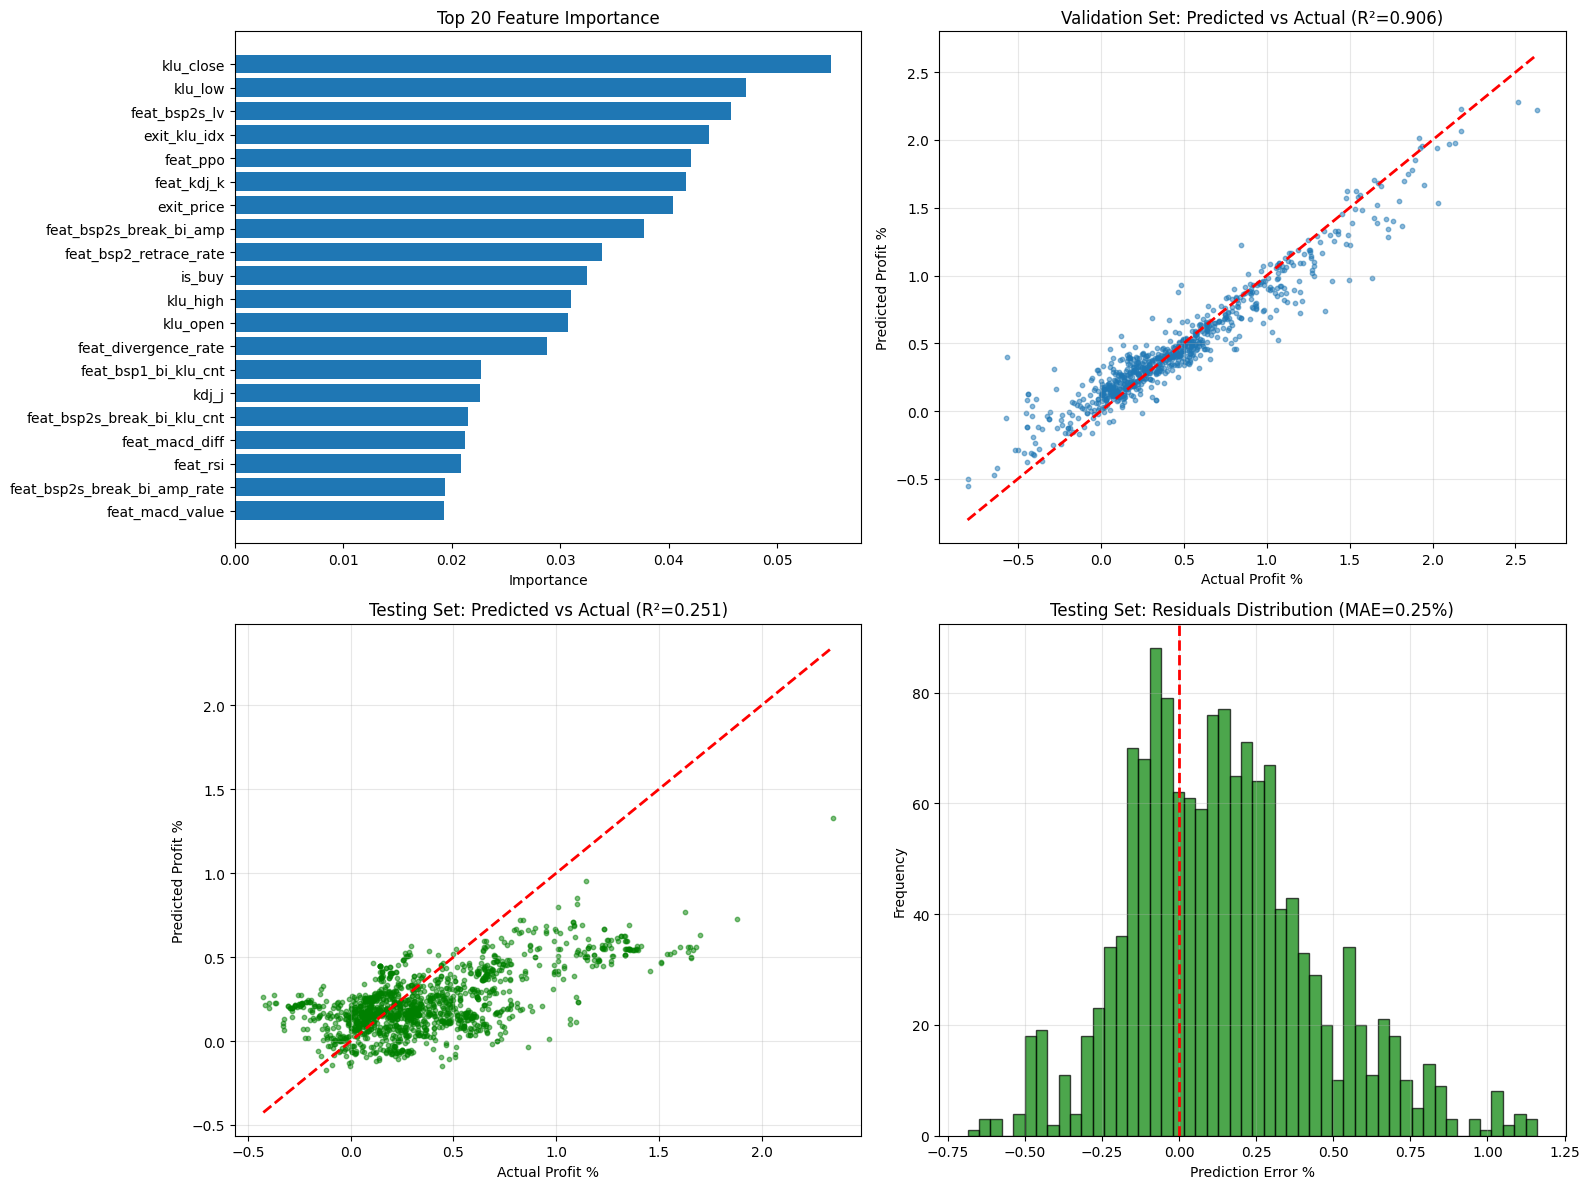

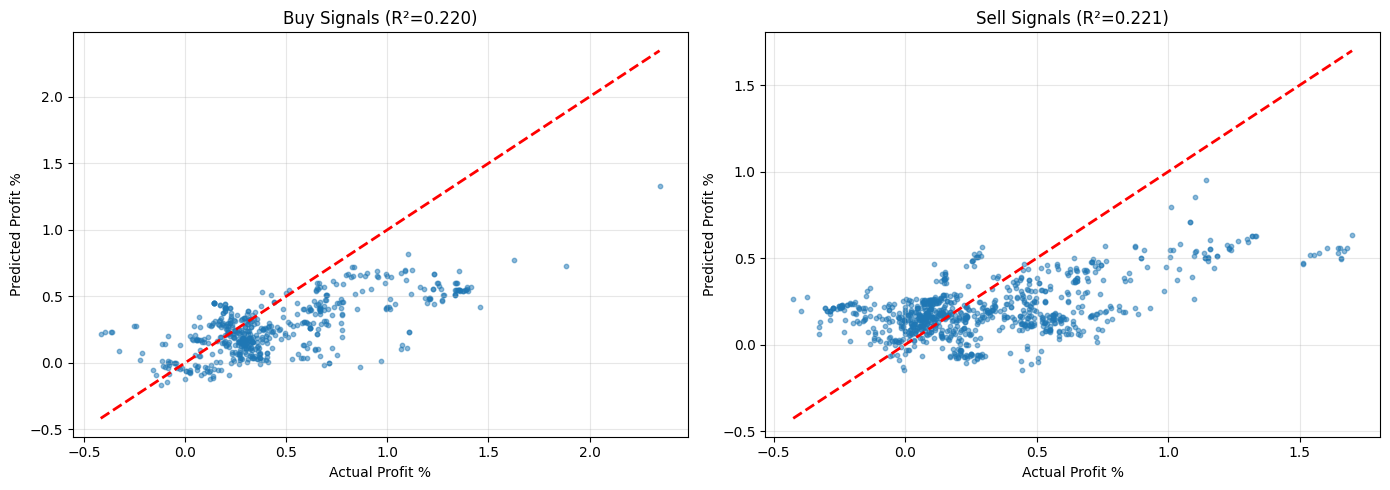

In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuration
TRAINING_DATA_PATH = "./output/enhanced_bs_features/^GSPC_ml_training_dataset.csv"
TESTING_DATA_PATH = "./output/testing_bs_features/^GSPC_testing_dataset.csv"
OUTPUT_DIR = "./output/model_results"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("XGBoost Trading Signal Model - Training and Testing")
print("=" * 80)

# Load datasets
print("\n[1/7] Loading datasets...")
train_df = pd.read_csv(TRAINING_DATA_PATH)
test_df = pd.read_csv(TESTING_DATA_PATH)

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

# Identify common features
print("\n[2/7] Identifying common features...")

# Exclude metadata and target columns
exclude_patterns = ['timestamp', 'bsp_type', 'direction', 'profit_target', 
                   'has_profit', 'return_', 'label_', 'target_return_', 
                   'snapshot_', 'klu_idx', 'exit_type']

train_cols = set(train_df.columns)
test_cols = set(test_df.columns)

# Get common columns
common_cols = train_cols.intersection(test_cols)

# Filter to feature columns only
feature_cols = [col for col in common_cols 
                if not any(col.startswith(pattern) for pattern in exclude_patterns)]

# Remove encoded columns if original exists
if 'direction' in feature_cols and 'direction_encoded' in feature_cols:
    feature_cols.remove('direction')
if 'bsp_type' in feature_cols and 'bsp_type_encoded' in feature_cols:
    feature_cols.remove('bsp_type')

feature_cols = sorted(feature_cols)

print(f"Common features found: {len(feature_cols)}")
print("\nFeature list:")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i:3d}. {feat}")

# Prepare training data
print("\n[3/7] Preparing training data...")

# Filter for valid training samples
train_valid = train_df[train_df['has_profit_target'] == 1].copy()
print(f"Valid training samples: {len(train_valid)}/{len(train_df)}")

# Extract features and target
X_train_full = train_valid[feature_cols]
y_train_full = train_valid['profit_target_pct']

# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    random_state=42
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")

# Prepare testing data
print("\n[4/7] Preparing testing data...")

test_valid = test_df[test_df['has_profit_target'] == 1].copy()
print(f"Valid testing samples: {len(test_valid)}/{len(test_df)}")

X_test = test_valid[feature_cols]
y_test = test_valid['profit_target_pct']

# Handle missing values
print("\n[5/7] Handling missing values...")
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

# Train XGBoost model
print("\n[6/7] Training XGBoost model...")

# Model parameters - updated for newer XGBoost API
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 20  # Include here for newer versions
}

model = xgb.XGBRegressor(**params)

# Train with eval_set for monitoring
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Get best scores
try:
    print(f"Best iteration: {model.best_iteration}")
    print(f"Best score: {model.best_score:.4f}")
except AttributeError:
    print("Model trained successfully")

# Make predictions
print("\n[7/7] Evaluating model...")

# Predictions on validation set
y_val_pred = model.predict(X_val)

# Predictions on test set
y_test_pred = model.predict(X_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Trading metrics
    correct_direction = np.sum((y_true > 0) == (y_pred > 0))
    accuracy = correct_direction / len(y_true) * 100
    
    print(f"\n{dataset_name} Metrics:")
    print(f"  RMSE: {rmse:.4f}%")
    print(f"  MAE: {mae:.4f}%")
    print(f"  R²: {r2:.4f}")
    print(f"  Direction Accuracy: {accuracy:.2f}%")
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Accuracy': accuracy
    }

val_metrics = calculate_metrics(y_val, y_val_pred, "Validation Set")
test_metrics = calculate_metrics(y_test, y_test_pred, "Testing Set")

# Feature importance
print("\nTop 20 Most Important Features:")
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

for i, row in feature_importance.head(20).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")

# Visualizations
print("\nGenerating visualizations...")

# 1. Feature Importance Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top 20 features
top_features = feature_importance.head(20)
axes[0, 0].barh(range(len(top_features)), top_features['importance'].values)
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels(top_features['feature'].values)
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Top 20 Feature Importance')
axes[0, 0].invert_yaxis()

# 2. Prediction vs Actual (Validation)
axes[0, 1].scatter(y_val, y_val_pred, alpha=0.5, s=10)
axes[0, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Profit %')
axes[0, 1].set_ylabel('Predicted Profit %')
axes[0, 1].set_title(f'Validation Set: Predicted vs Actual (R²={val_metrics["R2"]:.3f})')
axes[0, 1].grid(True, alpha=0.3)

# 3. Prediction vs Actual (Testing)
axes[1, 0].scatter(y_test, y_test_pred, alpha=0.5, s=10, color='green')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Profit %')
axes[1, 0].set_ylabel('Predicted Profit %')
axes[1, 0].set_title(f'Testing Set: Predicted vs Actual (R²={test_metrics["R2"]:.3f})')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals Distribution
residuals_test = y_test - y_test_pred
axes[1, 1].hist(residuals_test, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Prediction Error %')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Testing Set: Residuals Distribution (MAE={test_metrics["MAE"]:.2f}%)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/model_evaluation.png", dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/model_evaluation.png")

# 2. Prediction Analysis by Signal Type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Add predictions to test dataframe
test_valid['predicted_profit'] = y_test_pred

# By direction
for idx, direction in enumerate(['buy', 'sell']):
    dir_data = test_valid[test_valid['direction'] == direction]
    
    if len(dir_data) > 0:
        axes[idx].scatter(dir_data['profit_target_pct'], 
                         dir_data['predicted_profit'], 
                         alpha=0.5, s=10)
        axes[idx].plot([dir_data['profit_target_pct'].min(), 
                        dir_data['profit_target_pct'].max()],
                       [dir_data['profit_target_pct'].min(), 
                        dir_data['profit_target_pct'].max()], 
                       'r--', lw=2)
        
        r2 = r2_score(dir_data['profit_target_pct'], dir_data['predicted_profit'])
        axes[idx].set_xlabel('Actual Profit %')
        axes[idx].set_ylabel('Predicted Profit %')
        axes[idx].set_title(f'{direction.capitalize()} Signals (R²={r2:.3f})')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/prediction_by_direction.png", dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/prediction_by_direction.png")

# Save detailed results
print("\nSaving detailed results...")

# Test predictions with metadata
results_df = test_valid.copy()
results_df['predicted_profit_pct'] = y_test_pred
results_df['prediction_error'] = y_test - y_test_pred
results_df['correct_direction'] = (
    (results_df['profit_target_pct'] > 0) == (results_df['predicted_profit_pct'] > 0)
).astype(int)

results_df.to_csv(f"{OUTPUT_DIR}/test_predictions.csv", index=False)
print(f"Saved: {OUTPUT_DIR}/test_predictions.csv")

# Summary report
with open(f"{OUTPUT_DIR}/model_summary.txt", 'w') as f:
    f.write("XGBoost Trading Signal Model - Summary Report\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("DATA:\n")
    f.write(f"  Training samples: {len(X_train)} (validation: {len(X_val)})\n")
    f.write(f"  Testing samples: {len(X_test)}\n")
    f.write(f"  Features used: {len(feature_cols)}\n\n")
    
    f.write("MODEL PARAMETERS:\n")
    for key, value in params.items():
        f.write(f"  {key}: {value}\n")
    
    f.write("\nVALIDATION SET PERFORMANCE:\n")
    for metric, value in val_metrics.items():
        f.write(f"  {metric}: {value:.4f}\n")
    
    f.write("\nTESTING SET PERFORMANCE:\n")
    for metric, value in test_metrics.items():
        f.write(f"  {metric}: {value:.4f}\n")
    
    f.write("\nTOP 10 FEATURES:\n")
    for i, row in feature_importance.head(10).iterrows():
        f.write(f"  {i+1}. {row['feature']}: {row['importance']:.4f}\n")
    
    f.write("\nPERFORMANCE BY DIRECTION:\n")
    for direction in ['buy', 'sell']:
        dir_data = results_df[results_df['direction'] == direction]
        if len(dir_data) > 0:
            dir_acc = dir_data['correct_direction'].mean() * 100
            dir_mae = mean_absolute_error(dir_data['profit_target_pct'], 
                                           dir_data['predicted_profit_pct'])
            f.write(f"  {direction.capitalize()}:\n")
            f.write(f"    Samples: {len(dir_data)}\n")
            f.write(f"    Direction Accuracy: {dir_acc:.2f}%\n")
            f.write(f"    MAE: {dir_mae:.4f}%\n")

print(f"Saved: {OUTPUT_DIR}/model_summary.txt")

# Save model
model.save_model(f"{OUTPUT_DIR}/xgboost_model.json")
print(f"Saved: {OUTPUT_DIR}/xgboost_model.json")

print("\n" + "=" * 80)
print("Model Training and Testing Complete!")
print("=" * 80)
print(f"\nResults saved to: {OUTPUT_DIR}/")
print(f"\nKey Findings:")
print(f"  - Testing R²: {test_metrics['R2']:.4f}")
print(f"  - Testing MAE: {test_metrics['MAE']:.4f}%")
print(f"  - Direction Accuracy: {test_metrics['Accuracy']:.2f}%")
print(f"  - Model can predict profit direction correctly {test_metrics['Accuracy']:.1f}% of the time")

# Trading simulation summary
profitable_trades = (results_df['profit_target_pct'] > 0).sum()
total_trades = len(results_df)
actual_win_rate = profitable_trades / total_trades * 100

predicted_profitable = (results_df['predicted_profit_pct'] > 0).sum()
predicted_win_rate = predicted_profitable / total_trades * 100

print(f"\nTrading Statistics:")
print(f"  Actual profitable trades: {profitable_trades}/{total_trades} ({actual_win_rate:.1f}%)")
print(f"  Predicted profitable: {predicted_profitable}/{total_trades} ({predicted_win_rate:.1f}%)")
print(f"  Model identifies profitable signals with {test_metrics['Accuracy']:.1f}% accuracy")

plt.show()

Portfolio Backtesting: ML Trading Strategy vs Buy & Hold

[1/4] Loading test predictions...
Total signals: 1424
Date range: 2024/05/02 03:40 to 2024/05/31 12:25

[2/4] Running backtest...

[3/4] Calculating performance metrics...

BACKTEST RESULTS

Initial Capital: $10,000.00
Trading Period: 2024/05/02 03:40 to 2024/05/31 12:25
Total Signals: 1424

--------------------------------------------------------------------------------
ML TRADING STRATEGY
--------------------------------------------------------------------------------
Strategy: BUY when predicted profit > 0.4%, SELL on sell signal
Position Size: 100% per trade
Final Portfolio Value: $10,323.05
Total Return: 3.23%
Max Drawdown: 0.82%
Total Trades: 33 (Completed: 33)
Winning Trades: 25/33 (75.8%)
Average Trade Return: 0.10%
Median Trade Return: 0.07%
Best Trade: 0.85%
Worst Trade: -0.51%
Sharpe Ratio (approx): 0.44
Win/Loss Ratio: 1.37

--------------------------------------------------------------------------------
BUY & HOLD S

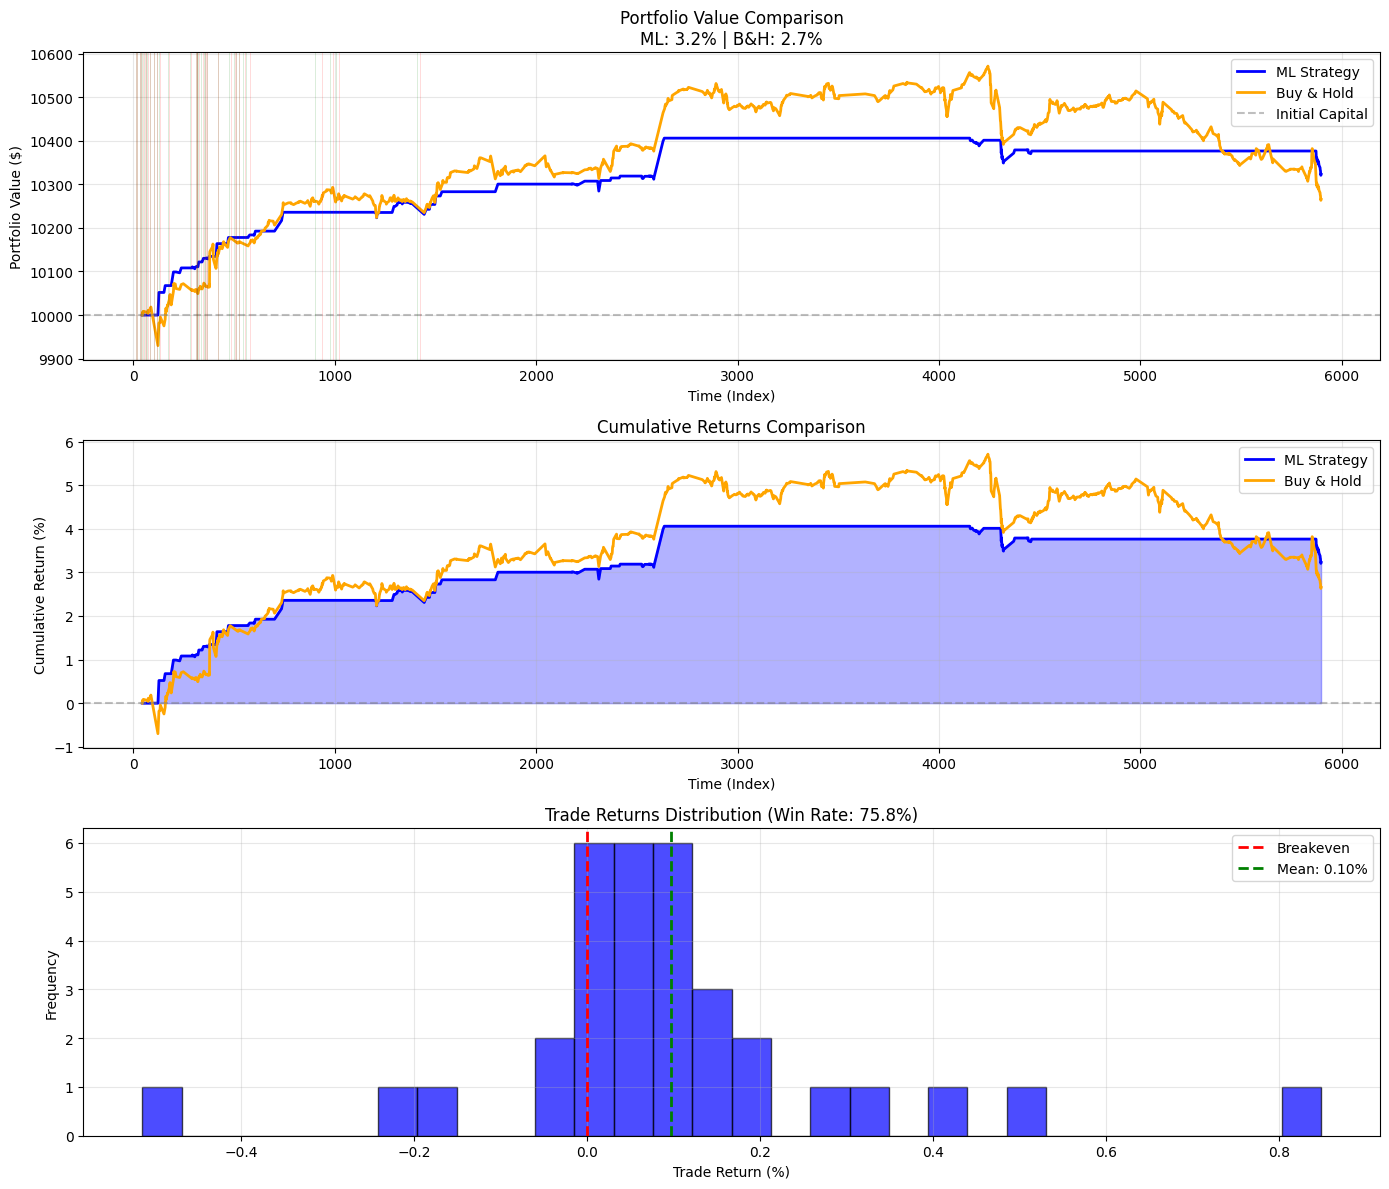

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Configuration
TEST_PREDICTIONS_PATH = "./output/model_results/test_predictions.csv"
OUTPUT_DIR = "./output/backtest_results"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Strategy parameters
PROFIT_THRESHOLD = 0.4  # Only trade if predicted profit > 0.4%
POSITION_SIZE = 1       # Use 100% of capital per trade
INITIAL_CAPITAL = 10000

print("=" * 80)
print("Portfolio Backtesting: ML Trading Strategy vs Buy & Hold")
print("=" * 80)

# Load predictions
print("\n[1/4] Loading test predictions...")
df = pd.read_csv(TEST_PREDICTIONS_PATH)

# Sort by timestamp to ensure chronological order
df = df.sort_values('klu_idx').reset_index(drop=True)

print(f"Total signals: {len(df)}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# Initialize portfolios
print("\n[2/4] Running backtest...")

# ML Strategy Portfolio
ml_capital = INITIAL_CAPITAL
ml_cash = INITIAL_CAPITAL
ml_shares = 0  # Number of shares held
ml_entry_price = 0
ml_portfolio_values = []
ml_trades = []
ml_returns = []
ml_skipped_sells = 0  # Track skipped sell signals

# Buy & Hold Portfolio
bh_capital = INITIAL_CAPITAL
bh_entry_price = df.iloc[0]['klu_close']
bh_shares = bh_capital / bh_entry_price
bh_portfolio_values = []

# Process each signal
for idx, row in df.iterrows():
    current_price = row['klu_close']
    predicted_profit = row['predicted_profit_pct']
    actual_profit = row['profit_target_pct']
    direction = row['direction']
    
    # === ML Strategy Logic ===
    
    if direction == 'buy' and ml_shares == 0 and predicted_profit >= PROFIT_THRESHOLD:
        # BUY signal: Enter position if we predict profit > threshold
        trade_capital = ml_cash * POSITION_SIZE
        ml_shares = trade_capital / current_price
        ml_entry_price = current_price
        ml_cash -= trade_capital
        
        ml_trades.append({
            'entry_idx': idx,
            'entry_timestamp': row['timestamp'],
            'direction': 'buy',
            'entry_price': current_price,
            'predicted_profit': predicted_profit,
            'position_size': trade_capital,
            'shares': ml_shares
        })
    
    elif direction == 'sell' and ml_shares > 0:
        # SELL signal: Exit position ONLY if predicted profit > threshold
        if predicted_profit >= PROFIT_THRESHOLD:
            exit_value = ml_shares * current_price
            trade_profit = exit_value - (ml_shares * ml_entry_price)
            trade_return_pct = (trade_profit / (ml_shares * ml_entry_price)) * 100
            
            ml_cash += exit_value
            
            # Record trade result
            if ml_trades:
                ml_trades[-1].update({
                    'exit_idx': idx,
                    'exit_timestamp': row['timestamp'],
                    'exit_price': current_price,
                    'exit_predicted_profit': predicted_profit,
                    'actual_profit': actual_profit,
                    'trade_profit': trade_profit,
                    'trade_return_pct': trade_return_pct
                })
                ml_returns.append(trade_return_pct)
            
            # Reset position
            ml_shares = 0
            ml_entry_price = 0
        else:
            # Skip this sell signal (predicted profit too low)
            ml_skipped_sells += 1
    
    # Calculate current portfolio value
    position_value = ml_shares * current_price
    ml_portfolio_value = ml_cash + position_value
    ml_portfolio_values.append(ml_portfolio_value)
    
    # === Buy & Hold Strategy ===
    bh_portfolio_value = bh_shares * current_price
    bh_portfolio_values.append(bh_portfolio_value)

# Close any open position at the end
if ml_shares > 0:
    final_price = df.iloc[-1]['klu_close']
    exit_value = ml_shares * final_price
    trade_profit = exit_value - (ml_shares * ml_entry_price)
    trade_return_pct = (trade_profit / (ml_shares * ml_entry_price)) * 100
    
    ml_cash += exit_value
    
    if ml_trades:
        ml_trades[-1].update({
            'exit_idx': len(df) - 1,
            'exit_timestamp': df.iloc[-1]['timestamp'],
            'exit_price': final_price,
            'exit_predicted_profit': None,
            'actual_profit': None,
            'trade_profit': trade_profit,
            'trade_return_pct': trade_return_pct,
            'note': 'Closed at end of period'
        })
        ml_returns.append(trade_return_pct)
    
    ml_portfolio_values[-1] = ml_cash

# Add portfolio values to dataframe
df['ml_portfolio_value'] = ml_portfolio_values
df['bh_portfolio_value'] = bh_portfolio_values

# Calculate metrics
print("\n[3/4] Calculating performance metrics...")

# ML Strategy Metrics
ml_final_value = ml_portfolio_values[-1]
ml_total_return = ((ml_final_value - INITIAL_CAPITAL) / INITIAL_CAPITAL) * 100
ml_completed_trades = len([t for t in ml_trades if 'exit_price' in t])
ml_winning_trades = len([t for t in ml_trades if 'trade_profit' in t and t['trade_profit'] > 0])
ml_win_rate = (ml_winning_trades / ml_completed_trades * 100) if ml_completed_trades > 0 else 0

# Buy & Hold Metrics
bh_final_value = bh_portfolio_values[-1]
bh_total_return = ((bh_final_value - INITIAL_CAPITAL) / INITIAL_CAPITAL) * 100

# Calculate max drawdown for ML strategy
ml_peak = INITIAL_CAPITAL
ml_max_drawdown = 0
for value in ml_portfolio_values:
    if value > ml_peak:
        ml_peak = value
    drawdown = ((ml_peak - value) / ml_peak) * 100
    if drawdown > ml_max_drawdown:
        ml_max_drawdown = drawdown

# Print results
print("\n" + "=" * 80)
print("BACKTEST RESULTS")
print("=" * 80)

print(f"\nInitial Capital: ${INITIAL_CAPITAL:,.2f}")
print(f"Trading Period: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Total Signals: {len(df)}")

print("\n" + "-" * 80)
print("ML TRADING STRATEGY")
print("-" * 80)
print(f"Strategy: BUY/SELL only when predicted profit > {PROFIT_THRESHOLD}%")
print(f"Position Size: {POSITION_SIZE*100}% per trade")
print(f"Final Portfolio Value: ${ml_final_value:,.2f}")
print(f"Total Return: {ml_total_return:.2f}%")
print(f"Max Drawdown: {ml_max_drawdown:.2f}%")
print(f"Total Trades: {len(ml_trades)} (Completed: {ml_completed_trades})")
print(f"Winning Trades: {ml_winning_trades}/{ml_completed_trades} ({ml_win_rate:.1f}%)")
print(f"Skipped Sell Signals: {ml_skipped_sells} (predicted profit < threshold)")

if ml_returns:
    print(f"Average Trade Return: {np.mean(ml_returns):.2f}%")
    print(f"Median Trade Return: {np.median(ml_returns):.2f}%")
    print(f"Best Trade: {max(ml_returns):.2f}%")
    print(f"Worst Trade: {min(ml_returns):.2f}%")
    if len(ml_returns) > 1:
        print(f"Sharpe Ratio (approx): {np.mean(ml_returns) / np.std(ml_returns):.2f}")
        winning_returns = [r for r in ml_returns if r > 0]
        losing_returns = [r for r in ml_returns if r < 0]
        if winning_returns and losing_returns:
            print(f"Win/Loss Ratio: {np.mean(winning_returns) / abs(np.mean(losing_returns)):.2f}")

print("\n" + "-" * 80)
print("BUY & HOLD STRATEGY")
print("-" * 80)
print(f"Entry Price: ${bh_entry_price:.2f}")
print(f"Final Price: ${df.iloc[-1]['klu_close']:.2f}")
print(f"Shares Held: {bh_shares:.4f}")
print(f"Final Portfolio Value: ${bh_final_value:,.2f}")
print(f"Total Return: {bh_total_return:.2f}%")

print("\n" + "-" * 80)
print("COMPARISON")
print("-" * 80)
print(f"ML Strategy vs Buy & Hold: {ml_total_return - bh_total_return:+.2f}%")
print(f"ML Strategy Outperformance: {((ml_final_value / bh_final_value - 1) * 100):+.2f}%")

if ml_total_return > bh_total_return:
    print(f"\n✅ The ML strategy OUTPERFORMED buy & hold!")
else:
    print(f"\n⚠️ The ML strategy UNDERPERFORMED buy & hold.")

# Visualizations
print("\n[4/4] Generating visualizations...")

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1. Portfolio Value Over Time
axes[0].plot(df['klu_idx'], df['ml_portfolio_value'], label='ML Strategy', linewidth=2, color='blue')
axes[0].plot(df['klu_idx'], df['bh_portfolio_value'], label='Buy & Hold', linewidth=2, color='orange')
axes[0].axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')

# Mark trades
buy_trades = [t for t in ml_trades if t['direction'] == 'buy']
for trade in buy_trades:
    axes[0].axvline(x=trade['entry_idx'], color='green', alpha=0.2, linewidth=0.5)
    if 'exit_idx' in trade:
        axes[0].axvline(x=trade['exit_idx'], color='red', alpha=0.2, linewidth=0.5)

axes[0].set_xlabel('Time (Index)')
axes[0].set_ylabel('Portfolio Value ($)')
axes[0].set_title(f'Portfolio Value Comparison\nML: {ml_total_return:.1f}% | B&H: {bh_total_return:.1f}%')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Cumulative Returns
ml_returns_series = (df['ml_portfolio_value'] / INITIAL_CAPITAL - 1) * 100
bh_returns_series = (df['bh_portfolio_value'] / INITIAL_CAPITAL - 1) * 100

axes[1].plot(df['klu_idx'], ml_returns_series, label='ML Strategy', linewidth=2, color='blue')
axes[1].plot(df['klu_idx'], bh_returns_series, label='Buy & Hold', linewidth=2, color='orange')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].fill_between(df['klu_idx'], ml_returns_series, 0, alpha=0.3, color='blue')
axes[1].set_xlabel('Time (Index)')
axes[1].set_ylabel('Cumulative Return (%)')
axes[1].set_title('Cumulative Returns Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Trade Distribution
if ml_returns:
    axes[2].hist(ml_returns, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Breakeven')
    axes[2].axvline(x=np.mean(ml_returns), color='green', linestyle='--', linewidth=2, 
                    label=f'Mean: {np.mean(ml_returns):.2f}%')
    axes[2].set_xlabel('Trade Return (%)')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title(f'Trade Returns Distribution (Win Rate: {ml_win_rate:.1f}%)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/backtest_comparison.png", dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/backtest_comparison.png")

# Save detailed trade log
if ml_trades:
    trades_df = pd.DataFrame(ml_trades)
    trades_df.to_csv(f"{OUTPUT_DIR}/trade_log.csv", index=False)
    print(f"Saved: {OUTPUT_DIR}/trade_log.csv")
    
    print("\nSample trades:")
    display_cols = ['entry_timestamp', 'entry_price', 'exit_price', 'exit_predicted_profit', 'trade_return_pct']
    available_cols = [col for col in display_cols if col in trades_df.columns]
    print(trades_df[available_cols].head(10))

# Save summary report
with open(f"{OUTPUT_DIR}/backtest_summary.txt", 'w') as f:
    f.write("Portfolio Backtesting Summary Report\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("STRATEGY PARAMETERS:\n")
    f.write(f"  Profit Threshold: {PROFIT_THRESHOLD}%\n")
    f.write(f"  Position Size: {POSITION_SIZE*100}%\n")
    f.write(f"  Initial Capital: ${INITIAL_CAPITAL:,.2f}\n")
    f.write("  Strategy: BUY/SELL only when predicted profit > threshold\n")
    f.write("  Note: Both entry AND exit require profit threshold\n\n")
    
    f.write("ML TRADING STRATEGY:\n")
    f.write(f"  Final Value: ${ml_final_value:,.2f}\n")
    f.write(f"  Total Return: {ml_total_return:.2f}%\n")
    f.write(f"  Max Drawdown: {ml_max_drawdown:.2f}%\n")
    f.write(f"  Total Trades: {len(ml_trades)}\n")
    f.write(f"  Completed Trades: {ml_completed_trades}\n")
    f.write(f"  Win Rate: {ml_win_rate:.1f}%\n")
    f.write(f"  Skipped Sell Signals: {ml_skipped_sells}\n")
    if ml_returns:
        f.write(f"  Average Trade Return: {np.mean(ml_returns):.2f}%\n")
        f.write(f"  Median Trade Return: {np.median(ml_returns):.2f}%\n")
        f.write(f"  Best Trade: {max(ml_returns):.2f}%\n")
        f.write(f"  Worst Trade: {min(ml_returns):.2f}%\n")
    
    f.write("\nBUY & HOLD STRATEGY:\n")
    f.write(f"  Final Value: ${bh_final_value:,.2f}\n")
    f.write(f"  Total Return: {bh_total_return:.2f}%\n")
    
    f.write("\nCOMPARISON:\n")
    f.write(f"  ML vs B&H: {ml_total_return - bh_total_return:+.2f}%\n")
    f.write(f"  Outperformance: {((ml_final_value / bh_final_value - 1) * 100):+.2f}%\n")

print(f"Saved: {OUTPUT_DIR}/backtest_summary.txt")

print("\n" + "=" * 80)
print("Backtesting Complete!")
print("=" * 80)

print(f"\nKey Takeaways:")
print(f"  - ML Strategy made {ml_completed_trades} trades with {ml_win_rate:.1f}% win rate")
print(f"  - Average return per trade: {np.mean(ml_returns):.2f}%" if ml_returns else "  - No completed trades")
print(f"  - Skipped {ml_skipped_sells} sell signals (predicted profit < {PROFIT_THRESHOLD}%)")
print(f"  - Only {POSITION_SIZE*100}% of capital used per trade")
print(f"  - Both BUY and SELL require predicted profit > {PROFIT_THRESHOLD}%")

plt.show()